<a href="https://colab.research.google.com/github/bmf87/ml-ds-projects/blob/main/ds552/wk4_assign4_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS 552 - Generative AI
* Assignment 4: Generative Adversarial Networks (GANs)
* Datasets: MNIST and CIFAR-10
* Author: Brett Favro


GANs are generative models comprimsed of two neural networks, a Generator and a Discriminator, that compete with each other, e.g. two-player, zero-sum non-cooperative game based on game theory. The two networks compete until they reach a [Nash equilibrium](https://www.geeksforgeeks.org/machine-learning/nash-equilibrium/) where the generator produces indistinguishable data from the training set.

***At equilibrium:*** The Generator cannot fool the Discriminiator any better and the Discriminator cannot easily distinguish fake from real images

&nbsp;

**Objectives:**

1. Modify the Generator to include additioinal convolutional layers
2. Implement image savings after every 10 epochs
3. Replace the MNIST dataset with CIFAR-10 and update the network for the new dimensions




In [9]:
import os
import logging
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import SpectralNormalization
from dataclasses import dataclass
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy.linalg

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [32]:
#import keras
#print(keras.__version__)

3.10.0


## GAN Theory Questions

1. Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

> Minimax describes the game structure. The Generator (G) looks to minimize (min_G) loss while the Discriminator (D) looks to maximizes it (max_D). Each has an objective to pull a "shared value score *V(D, G)* in opposite directions with their optimization goals.

> Shared V(D,G): E(log D(real)] + E[log(1-D(fake))]

>  * G minimizes the shared value function *V(D, G)*.
    * G pulls V downward when fooling D
    * G's goal --> fool D into thinking fake images are real
    * G is rewarded when *D(fake)* is high (close to 1.0), where *D(fake)* is the discriminator's probability output or the sigmoid of its final logit.

> * ***gen_loss** = BCE(D(fake), 1.0) or -log(D(fake))*.
This is the negative log-likelihood that the discriminator classifies fake data as real.

> * D(fake) = 1.0 (G winning --> fooling D with fakes)
> * gen_loss = -log(1.0) = 0 (Loss)
> * G wants V low (continue fooling D)

> $$\frac{\partial L_{G}}{\partial D(fake)} = -\frac{1}{1.0} = -1.0$$
> <br /> &emsp; *Produces a moderate negative gradients, which encourage the Generator to continue with more of the same*

> * D(fake) = 0.0 (D winning --> not being fooled)
> * gen_loss = -log(0.01) ~ 4.6 (Loss)

> $$\frac{\partial L_{G}}{\partial D(fake)} = -\frac{1}{0.01} = -100$$
> <br /> &emsp; *Produces a high gradient that when backpropagated, the generator's weights get a strong **push** to produce more realistic images*

> * D maximizes the shared value function *V(D, G)* when getting better at classification
    * D pushes V upward with accurate classifications of both real and fake images
    * D wants V high (better classifier)
    * By optimizing classification accuracy --> makes the G loss increase

> In Summary, both players optimize *V(D, G)* in opposing directions through gradient descent on their respective losses.
> * Equilibrium: V stabilizes when neither G or D can improve (*D(fake)* ~ 0.5)




2. What is mode collapse. Why can mode collapse occur during GAN training and how can it be mitigated?

> Mode collapse occurs when the generator produces limited outputs. It ignores the diversity in the real data distribution and generates images in the same or similar class. The distribution of data is ignored because the generator's optimization is stuck in a local minimum. One or few output types have minimized loss. The generator repeats these due to the low loss results. It wants to win!
>   * Mitigations include stabilizing the game/training. Reduce the discriminator's tendency to dominate. Discriminator domination pushes the generator into narrow outputs that produce mimimal loss results.
>   * How?
      * Label smoothing, balanced learning rates, regularization, or gradient penalities/clipping,
      * Label smoothing: reduces discriminator confidence, which in turn leads to useful feedback for the generator (non-zero gradients).
      * Regularization of discriminator: makes its gradients smoother and again more useful to generator training. Regularization causes the discriminator to broaden its decision boundary and create smoother gradients across larger regions. This can be accomplished with Spectral normalization (SN) which contrains the discriminator's weight matrix to a spectral norm of 1. For each weight matrix W in Conv2D/Linear layer this controls gradient magnitude and prevents exploding gradients.
      * Add Gaussian noise to images: this smooths loss and discourages the generator from collapsing into narrow patterns. Like regularizatioin, the added noise causes the discriminator to broaden its decision boundary of what's real and fake. A narrow decision boundary provides the generator a narrow band to exploit wins. Added noise leads to it leveraging a wider data distribution in its image generation.
     * Add minibatch discrimination layer: added towards the end of discriminator's network, this layer would compute similarity between features in the same batch and feed it into the final classification layer. This makes identical outpus by the generator easier to detect. *Not to be confused with Inception Score (IS), which is an evaluation step*.


3. Explan the role of the discriminator in adversarial training?

> The discriminator is a binary classifier tasked with outputting a probability that a generated image is either real (1: from dataset) or fake (0: made by generator). The discriminator provides feedback to the generator that provides gradients that ultimately guide/teach the generator from early noise --> textures --> coherent image semantics. This feedback allows the generator to get better at generating images that are difficult to decipher between real vs fake.
  > * Feedback flows to the generator via classification loss calculated by Binary Cross-Entry (BCE) during backpropagation.


4. How do metrics like IS and FID evaluate GAN performance? Both metrics use a pretrained Inception-v3 network.

> IS and FID use Inception-v3 (pretrained CNN) to extract high-level features from generated images.

>    * **Inception Score (IS)** - measures generated image quality and diversity using Inception-v3. For each generated image *x*, it provides a label distribution *p(y|x)* and then compares it against the dataset-wide marginal *p(y)* using KL divergence.
      * KL divergence measures how much each image's predicted class distribution *p(y|x)* differs from the average distribution *p(y)*
      * If your images are sharp and cover many classes, IS will be high (good).
      * IS is better suited to answer the question of whether your generated images are clear, sharp and diverse (high entropy across dataset).
      * IS does not look at real data. It tells you whether your generated images are "confidently" a class and if they cover many classes.

 >   * **Frechet Inception Distance (FID)** - compares generated vs real distributions. FID computes the Frechet (Wasserstein-2) distance between the Gaussian distributions of features from both real and generated images. It compares mean and covariance (correlations & spread) feature vectors across real and generated image sets.
      * A lower FID indicates better similarity between real and generated.
      * FID compares to real data and correlates very well with human judgement.
      * Considered the gold standard. FID answers the question of whether your generated images match real data distributions, or in other words, are they statistically indistinguishable from real ones.


## GAN Model Architecture
* DCGAN: Deep Convolutional Generative Adversarial Network
* Improves GANs by utlizing convolutional and transposed conv layers
* Added additional Conv2D layers for progressive refinement->artifact free. Adding "thinking time" at each scale.
  * Block 1/Layer 2: 7x7 (MNIST) or 8x8 (CIFAR-10) Refinement: clean initial projection from dense layer
  * Block 2/Layer 4: 14x14 (MNIST) or 16x16 (CIFAR-10) Refinement: fixes upsampling artifacts

In [21]:
# Generator model
def make_generator_model(output_shape=(28,28,1)):
    h, w, c = output_shape
    start_h = h // 4
    start_w = w // 4

    model = tf.keras.Sequential([
      layers.Input(shape=(100,)),
      # Project and reshape in 3D block
      # Increase depth from 256->384
      layers.Dense(start_h * start_w * 384, use_bias=False),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(negative_slope=0.2),
      layers.Dropout(0.1),  # Lower dropout: for sharper img

      layers.Reshape((start_h, start_w, 384)),

      # Upsample 1: Refine, maintain resolution
      layers.Conv2DTranspose(192, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(negative_slope=0.2),
      layers.Dropout(0.1),

      # Refine Layer
      layers.Conv2D(192, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(negative_slope=0.2),
      layers.Dropout(0.1),

      # Upsample 2
      layers.Conv2DTranspose(96, (5, 5), strides=(2, 2), padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(negative_slope=0.2),
      layers.Dropout(0.1),

      # Refine Layer
      layers.Conv2D(96, (5, 5), strides=(1, 1), padding='same', use_bias=False),
      layers.BatchNormalization(momentum=0.8),
      layers.LeakyReLU(negative_slope=0.2),
      layers.Dropout(0.1),

      # Upsample 3: output_shape
      layers.Conv2DTranspose(c, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

# Discriminator model
def make_discriminator_model(input_shape=(28, 28, 1)):
    model = tf.keras.Sequential([
      layers.Input(shape=input_shape),
      #layers.SpectralNormalization(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')),
      layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      #SpectralNormalization(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')),
      layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      # Capacity matches Generator (384)
      #layers.SpectralNormalization(layers.Conv2D(384, (5, 5), strides=(1, 1), padding='same')),
      layers.Conv2D(384, (5, 5), strides=(1, 1), padding='same'),
      layers.LeakyReLU(),
      layers.Dropout(0.3),

      layers.Flatten(),
      layers.SpectralNormalization(layers.Dense(1))
    ])
    return model

def instantiate_gan_models(input_shape=(28,28,1), show_summary=False):
  # Create models: explicitly build models to create variables
    try:
      generator = make_generator_model(output_shape=input_shape)
      print(f"Generator Input Shape: {generator.input_shape}")
      if show_summary:
        generator.summary()
    except Exception as e:
      print(f"Creation of GAN Generator Failed: {e}")
    try:
      discriminator = make_discriminator_model(input_shape=input_shape)
      print(f"Discriminator Input Shape: {discriminator.input_shape}")
      if show_summary:
        discriminator.summary()
    except Exception as e:
      print(f"Creation of GAN Discriminator Failed: {e}")

    return generator, discriminator

@dataclass(frozen=True, unsafe_hash=True)
class GAN:
    generator: tf.keras.Model
    discriminator: tf.keras.Model
    generator_optimizer: tf.keras.optimizers.Optimizer
    discriminator_optimizer: tf.keras.optimizers.Optimizer
    dataset_name: str = "MNIST"
    metric: str = "FID"
    num_fid_samples: int = 500

    # Hyperparameters
    learning_rate: float = 1e-4
    epochs: int = 50


## Training & Util Functions
* Model Training & Loss Functions
* Evaluation & Image Plotting

In [25]:
smoothing_val = 0.1
#smoothing_val = 0.15

# [BCE]: optimal for binary probabilistic classifiers (D)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# label_smoothing softens overconfidence. Consider range(0.05, 0.21)
sce = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                         label_smoothing=smoothing_val)

# Dial back TensorFlow logging
# TF Logging: # '0' = all (default), '1' = INFO, '2' = WARNING, '3' = ERROR
envs = {
    "TF_CPP_MIN_LOG_LEVEL": "3",
    "TF_ENABLE_ONEDNN_OPTS": "0"
}
os.environ.update(envs)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

def load_mnist_dataset(batch_sz, buffer_sz):
    # Load/Preprocess MNIST training data
    (train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
    train_images = train_images.reshape(-1, 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize to [-1, 1]
    # GANs expect consistent tensor dims
    # Prevent variable batch dim issues: using drop_remainder=True
    train_dataset = (tf.data.Dataset
                      .from_tensor_slices(train_images)
                      .shuffle(buffer_sz).batch(batch_sz, drop_remainder=True)
                      .prefetch(tf.data.AUTOTUNE)
    )
    return train_dataset

def load_cifar10_dataset(batch_sz, buffer_sz):
    # Load/Preprocess CIFAR-10 training data
    (train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()
    # Normalize pixel values
    train_images = train_images / 255.0
    train_dataset = (tf.data.Dataset
                        .from_tensor_slices((train_images))
                        .shuffle(buffer_sz).batch(batch_sz, drop_remainder=True)
                        .prefetch(tf.data.AUTOTUNE)
    )
    return train_dataset

def discriminator_loss(real_output, fake_output):
     # 1-sided label smoothing: smooth real labels (using sce) to avoid penalizing D for rejecting fakes
     real_loss = sce(tf.ones_like(real_output), real_output)
     fake_loss = bce(tf.zeros_like(fake_output), fake_output)
     return real_loss + fake_loss

def generator_loss(fake_output):
     return bce(tf.ones_like(fake_output), fake_output)


# # SNGAN Standard: Hinge Loss
# # Discriminator: min(0, -1 + D(x)) + min(0, -1 - D(G(z))) -> implemented as ReLU(1 - D(x)) + ReLU(1 + D(G(z)))
# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(tf.nn.relu(1.0 - real_output))
#     fake_loss = tf.reduce_mean(tf.nn.relu(1.0 + fake_output))
#     return real_loss + fake_loss

# # Generator: -mean(D(G(z)))
# def generator_loss(fake_output):
#     return -tf.reduce_mean(fake_output)

# --- DiffAugment: Differentiable Augmentation for Data-Efficient GAN Training ---
# Source: https://github.com/mit-han-lab/data-efficient-gans
def DiffAugment(x, policy='color,translation,cutout', channels_first=False):
    x = tf.cast(x, tf.float32)
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x

def rand_brightness(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    return x + magnitude

def rand_saturation(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    return (x - x_mean) * magnitude + x_mean

def rand_contrast(x):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    return (x - x_mean) * magnitude + x_mean

def rand_translation(x, ratio=0.125):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x

def rand_cutout(x, ratio=0.5):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape)
    x = x * (1 - tf.expand_dims(mask, 3))
    return x

AUGMENT_FNS = {
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}

# Training function
@tf.function
def train_step(images, gan:GAN):
    # Dynamic batch size to handle dataset variations
    current_batch_size = tf.shape(images)[0]
    noise = tf.random.normal([current_batch_size, 100])

    # DiffAugment Policy
    if gan.dataset_name == 'CIFAR-10':
        policy = 'translation,cutout'
    else:
        policy = 'translation,cutout'


    # Discriminator Training Loop: 2 iterations per G step
    # Combat Generator Dominance (78%) by training D more
    for _ in range(2):
        noise = tf.random.normal([current_batch_size, 100])
        with tf.GradientTape() as disc_tape:
            generated_images = gan.generator(noise, training=True)

            real_aug = DiffAugment(images, policy=policy)
            fake_aug = DiffAugment(generated_images, policy=policy)
            real_output = gan.discriminator(real_aug, training=True)
            fake_output = gan.discriminator(fake_aug, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_discriminator = disc_tape.gradient(disc_loss, gan.discriminator.trainable_variables)
        gan.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, gan.discriminator.trainable_variables))

    # Generator Training Loop: 1 iteration
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = gan.generator(noise, training=True)
      fake_aug = DiffAugment(generated_images, policy=policy)

      fake_output = gan.discriminator(fake_aug, training=True)
      gen_loss = generator_loss(fake_output)

      # Discriminator predictions
      mean_fakes = tf.reduce_mean(tf.sigmoid(fake_output))
      val_real_aug = DiffAugment(images, policy=policy)
      val_real_output = gan.discriminator(val_real_aug, training=True)
      mean_reals = tf.reduce_mean(tf.sigmoid(val_real_output))
      #tf.print("Mean probability of generated images being real:", tf.reduce_mean(predictions))


    gradients_of_generator = gen_tape.gradient(gen_loss, gan.generator.trainable_variables)
    gan.generator_optimizer.apply_gradients(zip(gradients_of_generator, gan.generator.trainable_variables))
    return mean_reals, mean_fakes

# Training loop
def train(dataset, gan: GAN):
    predictions = []
    epoch_images = []
    plotted_img = None

    for epoch in range(gan.epochs):
      for image_batch in dataset:
        predictions.append(train_step(image_batch, gan))

      # Save images every N epochs
      if (epoch + 1) % save_interval == 0:
        print(f"Epoch {epoch+1}: Saving images...")
        # Generate in inference mode w/ fixed seed
        # Attempt to see model improvement using same random noise vector
        generated_images = gan.generator(random_seed, training=False)
        epoch_images.append(generated_images)
        if gan.metric == 'FID':
          validate_fid(gan.generator, dataset, epoch+1, gan.num_fid_samples)

    if epoch_images:
      plotted_img = save_plot(epoch_images, len(epoch_images), gan.dataset_name)

    return predictions, plotted_img

# FID Model (Lazy load)
_inception_model = None
def get_inception_model():
    global _inception_model
    if _inception_model is None:
        # standard FID uses pool3 layer (2048 dims)
        _inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    return _inception_model

def calculate_fid(real_images, fake_images):
    """
    Calculates FID score for a batch of images.
    Input images should be in [-1, 1] range (tanh output).
    """
    model = get_inception_model()

    # 299x299 required for Inception
    real_resized = tf.image.resize(real_images, (299, 299))
    fake_resized = tf.image.resize(fake_images, (299, 299))

    act1 = model.predict(real_resized, verbose=0)
    act2 = model.predict(fake_resized, verbose=0)

    # Calculate Mean and Covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Compute Fréchet Distance
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))

    # Check for imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def validate_fid(generator, dataset, epoch_num, num_fid_samples=500):
    print("Calculating FID estimate (this may take a moment)...")
    try:
        real_samples = []

        # safely get samples regardless of dataset type
        iterator = iter(dataset)
        num_batches = num_fid_samples // BATCH_SIZE + 1

        for _ in range(num_batches):
            try:
                real_samples.append(next(iterator))
            except StopIteration:
                # If dataset runs out, just use what we have
                break

        if not real_samples:
            print("FID Error: No real samples could be obtained from dataset.")
            return

        real_samples = tf.concat(real_samples, axis=0)[:num_fid_samples]

        # Generate fake
        noise_fid = tf.random.normal([real_samples.shape[0], 100])
        fake_samples = generator(noise_fid, training=False)

        # Handle Grayscale -> RGB
        if real_samples.shape[-1] == 1:
            real_samples = tf.image.grayscale_to_rgb(real_samples)
            fake_samples = tf.image.grayscale_to_rgb(fake_samples)

        fid_score = calculate_fid(real_samples, fake_samples)
        print(f"Epoch {epoch_num} FID Score: {fid_score:.4f}")

    except Exception as e:
        print(f"Skipping FID calculation due to error: {e}")
        import traceback
        traceback.print_exc()

# Evaluate outputs (real and fake) for Dominance
def evaluate_predictions(predictions):
    """
    Provide summary of Discriminator predictions on real and fake output

    Using MNIST: 60,000 images
      60000/batch size = 60000/256 = ~235 batches
      235*epochs = 235 * 50 = 11,750 mean predictions

    """
    generator_wins = discriminator_wins = equilibrium_hits = 0
    # evaluate means
    for p_real, p_fake in predictions:
        # Discriminator Dominating (Strong)
        # Real > 0.75 (Relaxed from 0.8 due to smoothing target ~0.9) AND Fake < 0.25
        #if p_real > 0.8 and p_fake < 0.2:
        if p_real > 0.75 and p_fake < 0.25:
            discriminator_wins += 1

        # Generator Dominating (D is Fooled or Confused)
        # Real < 0.5 (D confused about real) OR Fake > 0.6 (D fooled by fake)
        elif p_real < 0.5 or p_fake > 0.6:
            generator_wins += 1

        # Equilibrium (Healthy Training)
        # Real [0.5, 0.8], Fake [0.2, 0.6]
        else:
            equilibrium_hits += 1

    summary = {
        "Generator Wins (D Fooled/Confused)": generator_wins,
        "Discriminator Dominance": discriminator_wins,
        "Equilibrium (Healthy)": equilibrium_hits
    }
    return summary

# Helper function to save plot
def save_plot(epoch_images, rows, save_img='gan_training_progress.png'):
    cols = num_imgs_to_gen
    fig = plt.figure(figsize=(cols, rows))

    # epoch_images: list of [Tensor(16, 28, 28, 1), Tensor(16, 28, 28, 1), ...]
    # We want to flatten this into a grid

    cnt = 0
    for row_idx, images in enumerate(epoch_images):
         for col_idx in range(cols):
             img = images[col_idx] # Shape (H, W, C)
             # Denormalize
             img = img * 127.5 + 127.5
             img = img.numpy().astype(np.uint8)

             # Handle Grayscale and RGB
             if img.shape[-1] == 1:
                 img = img[:, :, 0]
                 cmap = 'gray'
             else:
                 cmap = None

             ax = plt.subplot(rows, cols, cnt + 1)
             plt.imshow(img, cmap=cmap)
             plt.axis('off')
             if col_idx == 0:
                # Use text instead of ylabel so it's visible with axis('off')
                ax.text(-0.3, 0.5, f'Epoch {(row_idx + 1) * save_interval}',
                        transform=ax.transAxes,
                        verticalalignment='center',
                        horizontalalignment='right',
                        size='medium',
                        fontweight='bold')
             cnt += 1

    plt.tight_layout()
    save_dir = './results'
    os.makedirs(save_dir, exist_ok=True)
    fig_path = os.path.join(save_dir, save_img + str("_training_progress.png"))
    plt.savefig(fig_path)
    print(f"Saved training visualization to {fig_path}")
    plt.close()
    return fig_path

## MNIST: Model Training & Eval
* [MNIST dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) - a dataset of 70k (60k train/10k test) handwritten digits of 24x24-pixel grayscale images.

[GPUs Available]:  1
Running on GPU: /device:GPU:0

Total number of elements (batches): 234
Steps per epoch: 234
Epoch 10: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 10 FID Score: 90.1095
Epoch 20: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 20 FID Score: 41.1075
Epoch 30: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 30 FID Score: 36.8966
Epoch 40: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 40 FID Score: 30.6924
Epoch 50: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 50 FID Score: 32.9288
Saved training visualization to ./results/MNIST_training_progress.png

**** [Model Summary Results]: ****
Generator Wins (D Fooled/Confused): 2264 19.4%
Discriminator Dominance: 3 0.0%
Equilibrium (Healthy): 9433 80.6%


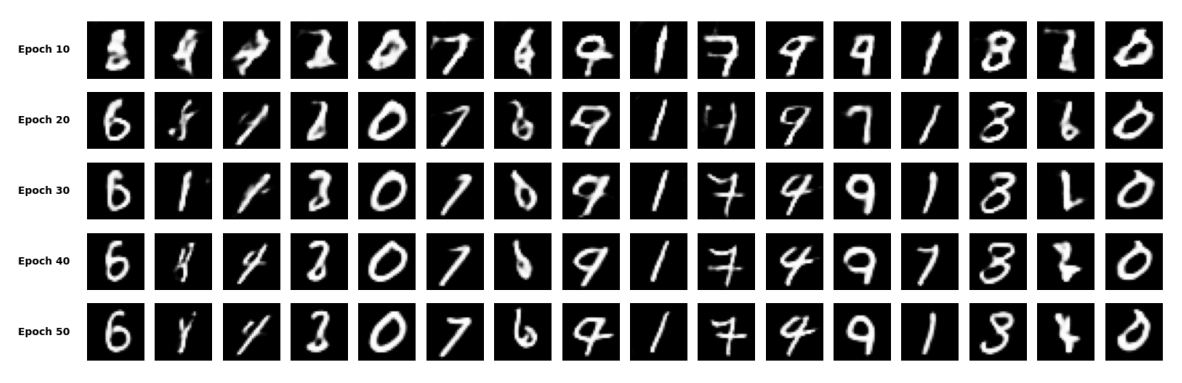

In [13]:
# Model/Dataset Config
#LR = 1e-4
LR = 2e-4
EPOCHS = 50
DS_NAME = "MNIST"
METRIC = "FID"
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Plotting Config
save_interval = 10
num_imgs_to_gen = 16
# Create random tensor (seed) filled from Gaussian dist.
random_seed = tf.random.normal([num_imgs_to_gen, 100])

# TF prioritizes GPUs
gpu_name = tf.test.gpu_device_name()
if gpu_name:
    print("[GPUs Available]: ", len(tf.config.list_physical_devices('GPU')))
    print(f"Running on GPU: {gpu_name}")
else:
    print("No GPU devices found")

# MNIST (28x28x1)
train_dataset = load_mnist_dataset(BATCH_SIZE, BUFFER_SIZE)
print(f"\nTotal number of elements (batches): {train_dataset.cardinality()}")
input_shape = (28, 28, 1)

steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
print(f"Steps per epoch: {steps_per_epoch}")

# LR Decay Schedule
# Start at 2e-4, then decay by 10% every 20 epochs to stabilize
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LR,
    decay_steps=steps_per_epoch * 20, # Decay every 20 epochs
    decay_rate=0.9,                   # reduce to 90% of current
    staircase=True
)
# Create GAN dataclass
gan = GAN(generator=make_generator_model(output_shape=input_shape),
          discriminator=make_discriminator_model(input_shape=input_shape),
          generator_optimizer=tf.keras.optimizers.Adam(
              learning_rate=lr_schedule,beta_1=0.5),
          discriminator_optimizer=tf.keras.optimizers.Adam(
              learning_rate=lr_schedule, beta_1=0.5),
          dataset_name=DS_NAME,
          metric=METRIC,
          num_fid_samples=500,
          epochs=EPOCHS)


predictions, plotted_imgs = train(train_dataset, gan)
summary = evaluate_predictions(predictions)
total = sum(summary.values())

# Display model training results
print("\n**** [Model Summary Results]: ****")
for key, value in summary.items():
  print(f"{key}: {value} {value/total:.1%}")

# Show image progression
img = mpimg.imread(plotted_imgs)
plt.figure(figsize=(15, 15)) # Make it big
plt.imshow(img)
plt.axis('off')
plt.show()

### Model Results

### **Training Runs:**
* Evaluated using:
  1. Discriminator prediction results
     * batch size * epochs: 234 * 50 = 11,700 mean predictions
  2. FID scores

##### **Final Run:** 50 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 2264 | 19.4% |
| Discriminator Wins | Dominants | 3 | 0.0% |
| Equilibrium | Healthy | 9433 | 80.6% |



&nbsp;

Multiple training iterations occurred before the final one documented above. The following changes were applied in a step-wise fashion:

1. One-sided label smoothing on the real-loss calculation. Objective was to avoid penalizing the Discriminator for correctly identifying fakes, yet still optimize/stabilize training.
2. Implemented learning rate decay to reduce the LR every 20 epochs by 10% (decay_rate=0.9).
3. Reduce momentum by adjusting *beta_1* in the Adam optimizer to 0.5.
    * Reduce momentum and prevent the optimizer from racing past the ideal solution or oscillating around.
4. Add an additional Conv2D layer to balance out the Discriminator capacity with the Generator. The Generator had a couple of training rounds were it heavily dominated.
5. Add dropout to each layer in the Generator. By dropping out 30% of the neurons, the Generator created more valid images vs relying on simply avergaing features, which was causing blur. This made a big difference on 32x32 images with the CIFAR-10 dataset.


Architecturally, the Generator is a more powerful model. It has more neural layers, parameters, and therefore overall capacity. But its job is much more complex.


* **Generator:** maps a vector of 100 numbers into a meaningful 784-pixel (28x28) image
* **Discriminator:** is a binary classifier that says Yes/No

The diversity found when analyzing the range of average probabilities indicates meaningful feedback was provided by the Discriminator to the Generator and therefore overall healthy model training occured.

**[FID Scores]** improve through epoch 40 to 30.6. The score increased through the final 10 epochs and probably could be configured for early stop since image quality declines a bit. Some images get better, a few worse. Overall, FID results are in the low end of the 30-50 range, indicating good production (close to strong), recognizable image semantics for the GAN.

&nbsp;

### **Generated Images:**

The MNIST dataset consists of handwritten single digits from 0 - 9 (10 classes). By using a fixed seed and the model in inference mode, we can track the evolution of a single digit down the columns from epoch 10->epoch 50.
* The first row is a combination of decipherable images and blurry, noisy blobs.
* Columns are showing different numbers - exhibiting some diversity, e.g. 0, 1, 2, 5, 6, 7, 8, etc..
  * If they were all showing the same => Mode Collapse
* By epoch 30, most of the number crystalize and are clear







## CIFAR-10: Model Training & Eval
* [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10) - an established computer-vision dataset used for object recognition compromised of 60k 32x32 color images.

[GPUs Available]:  1
Running on GPU: /device:GPU:0

Total number of elements (batches): 195
Steps per epoch: 195
Epoch 50: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 50 FID Score: 137.2436
Epoch 100: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 100 FID Score: 69.7847
Epoch 150: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 150 FID Score: 68.0436
Epoch 200: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 200 FID Score: 61.9409
Epoch 250: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 250 FID Score: 57.3959
Epoch 300: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 300 FID Score: 57.5044
Epoch 350: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 350 FID Score: 55.1511
Epoch 400: Saving images...
Calculating FID estimate (this may take a moment)...
Epoch 400 FID Score: 56.9827
Epoch 45

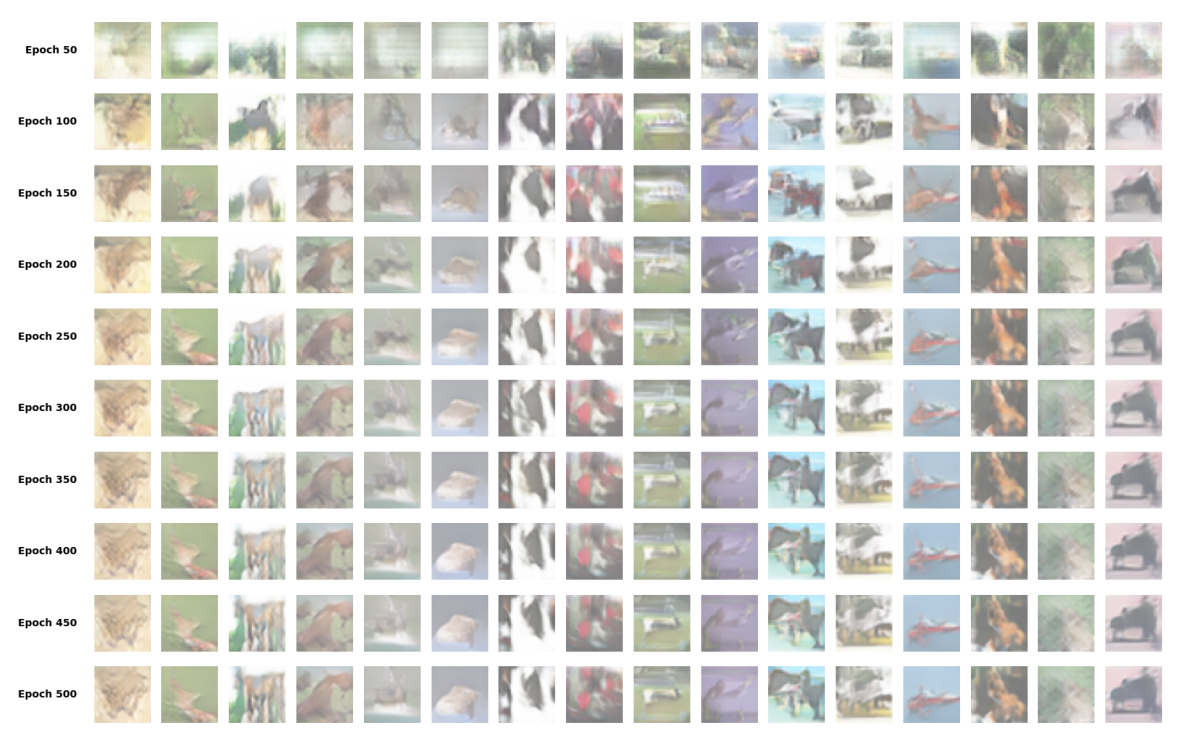

In [26]:
# Model/Dataset Config
#LR = 1e-4 # (1x10^(-4) 0.0001) - Spped: Very slow, Stability: Very high
LR = 2e-4  # (2x10^(-4) 0.0002) - Speed: Moderate, Stability: High
EPOCHS = 500
DS_NAME = "CIFAR-10"
METRIC = "FID"
BUFFER_SIZE = 50000
BATCH_SIZE = 256

# Plotting Config
save_interval = 50
num_imgs_to_gen = 16
# Create random tensor (seed) filled from Gaussian dist.
random_seed = tf.random.normal([num_imgs_to_gen, 100])

# TF prioritizes GPUs
gpu_name = tf.test.gpu_device_name()
if gpu_name:
    print("[GPUs Available]: ", len(tf.config.list_physical_devices('GPU')))
    print(f"Running on GPU: {gpu_name}")
else:
    print("No GPU devices found")

# CIFAR-10 (32x32x3)
train_dataset = load_cifar10_dataset(BATCH_SIZE, BUFFER_SIZE)
print(f"\nTotal number of elements (batches): {train_dataset.cardinality()}")
input_shape = (32, 32, 3)

# LR Decay Schedule - degradation observed around epoch 180
# Strategy: Start at 2e-4, then decay by 10% every 20 epochs to stabilize
# 50000 / 256 ~= 195 steps per epoch
dataset_size = len(train_dataset)
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE
print(f"Steps per epoch: {steps_per_epoch}")

# Learning Rate Decay Schedule
# Start at 2e-4, then decay by 10% every 20 epochs to stabilize
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=LR,
#     decay_steps=steps_per_epoch * 20, # Decay every 20 epochs
#     decay_rate=0.9,                   # reduce to 90% of current
#     staircase=True
# )

lr_schedule_gen = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, # Lower LR: stability
    decay_steps=steps_per_epoch * 20,
    decay_rate=0.9,
    staircase=True
)
lr_schedule_disc = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=4e-4, # Higher LR: better gradients (TTUR)
    decay_steps=steps_per_epoch * 20,
    decay_rate=0.9,
    staircase=True
)

# Create GAN dataclass
gan = GAN(generator=make_generator_model(output_shape=input_shape),
          discriminator=make_discriminator_model(input_shape=input_shape),
          generator_optimizer=tf.keras.optimizers.Adam(
              learning_rate=lr_schedule_gen,beta_1=0.5),
          discriminator_optimizer=tf.keras.optimizers.Adam(
              learning_rate=lr_schedule_disc, beta_1=0.5),
          dataset_name=DS_NAME,
          metric=METRIC,
          num_fid_samples=2000,
          epochs=EPOCHS)

predictions, plotted_imgs = train(train_dataset, gan)
summary = evaluate_predictions(predictions)
total = sum(summary.values())

# Display model training results
print("\n**** [Model Summary Results]: ****")
for key, value in summary.items():
  print(f"{key}: {value} {value/total:.1%}")

# Show image progression
img = mpimg.imread(plotted_imgs)
plt.figure(figsize=(15, 15)) # Make it big
plt.imshow(img)
plt.axis('off')
plt.show()

### Model Results

### **Training Runs:**
* Evaluated using:
  1. Discriminator prediction results
     * Used batch size * epochs: mean probabilities
     * Run 1: 195 * 50 = 9,750
     * Run 2: 195 * 100 = 19,500
     * Run 3-5: 195 * 200 = 39,000
     * Run 6+: 195 * 300 = 58,500
     * Run - Final: 195 * 500 = 97,500
  2. FID scores


&nbsp;

Many training iterations occurred with the CIFAR-10 dataset. It is a more complex dataset of 32x32x3 color images. In addition to the changes documented above for the MNIST dataset, the following changes were applied in a step-wise fashion:


1. Alpha / negative_slope added to the LeakyReLU activation function. For inputs x<0, the output is multipled by the negative_slop value. Allowing a non-zero gradient to flow backwards through the network for negative inputs.
   * This prevents inactive/dead neurons
2. Doubled the Generator capacity by:
   * Increased depth on dense layer from 256->512
   * Increased filter size on tranpose layer from 128->256
3. Add Gaussian noise to Discriminator input. This tactic adds *fog* to the images, which forces the Discriminator to learn broader features rather than memorizing pixel-perfect images.
4. ***Refined #2***. Doubling the Generator size made the Generator too heavy/hard to train relative to learning rate, batch size, and epochs. Generated images were quite a bit better before this capacity change.
I refined the capacity increase to 1.5x:
   * Increased depth on dense layer from 256->384
   * Increased filter size on tranpose layer from 128->192
For the Final run I increased to 500 epochs. Gaussian noise remained to increase image generation diversity, i.e. prevent mode collapse.
5. Based on high FID score (suboptimal): lowered dropout on all layers of the Generator to produce sharper images (preferred by InceptionV3). Implemented Two Time-Scale Update Rule (TTUR) by using separate LR for the Generator (lower) and Discriminator (higher). *Objective*: stabilitze training by enabling the Discriminator to learn complex boundaries before the Generator can ourrun it.
6. Changed momentum on Batch Normalization: with FID scores >100 the generator appears to be relying on stale running stats at the default setting (0.99). Lowering momentum to see the Generator use more of the data distribution.
7. Convergence failure with FID ~68. Implemented [Spectral Normalization](https://keras.io/api/layers/preprocessing_layers/numerical/spectral_normalization/) in the Discriminator's Conv2D layers.
Objective: loosen Discriminator boundaries and get generator unstuck. Required refactoring loss functions to use Hinge loss.
8. Removed SN - results worsened. Added Differentiable Augmentation (***DiffAugment***). This applies transformations to both the real and generated samples, make efficient use of data, and prevent the Discriminator from overfitting. Reduces FID scores by 2 - 4x.
   * Added 2x steps to the Discriminator per every Generator step. Prior results with SN shows Generator dominating 78.8% of the time.


##### **Run 1:** 50 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 1773 | 18.2% |
| Discriminator Wins | Dominants | 12 | 0.1% |
| Equilibrium | Healthy | 7965 | 81.7% |

<br />
After 50 epochs, the generator was producing undecipherable images. The images were early-stage noise or monochrome blobs, although sometimes interesting textures, there are real semantics yet.

#### **Summary of Runs 3 - 5:** 200 epochs each

* **Run 3:** After ~epoch 100, textures with semantics were forming in images but image quality was degrading by epoch 160.

* **Run 4:** Run 4 showed better results using learning rate decay. Again observed serious image degradation at ~epochs 160-180 (similar to run #3).

* **Run 5:** Run showed much better results by setting beta_1=0.5. More decipherable (semantics) and colorful images developed.

<br />

##### **Run 6:** 300 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 46400 | 79.3% |
| Discriminator Wins | Dominants | 0 | 0.0% |
| Equilibrium | Healthy | 12100 | 20.7% |


<br />
These results indicate the descriminator is being fooled way too easily. Image results show decipherable clarity (coherent shapes), but the Generator isn't being pushed hard enough to really perfect image details.


<br />

##### **Run 7:** 300 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 23195 | 39.6% |
| Discriminator Wins | Dominants | 7 | 0.0% |
| Equilibrium | Healthy | 35298 | 60.3% |

<br />
Results show a healthier balance after adding a Conv2D layer to the Discriminator. The Generator is winning much less (~40% less) and equilibrium has shifted >50%. Image results demonstrated the best clarity and texture so far, but still about half the images in epochs 250 and 300 show some blur.


<br />

##### **Run 8:** 300 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 10656 | 18.2% |
| Discriminator Wins | Dominants | 19 | 0.0% |
| Equilibrium | Healthy | 47825 | 81.8% |


<br />
Equilibrium is back to 80+%. Most of the image blur is gone after adding dropout. Most images show incredible improvement from epoch 100 onwards.


<br />

### **Final Summary:**

##### **Final:** 500 epochs

| Metric | Description | Number | Percentage |
|---|---|---|---|
| Generator Wins | D Fooled/Confused | 77115 | 79.1% |
| Discriminator Wins | Dominants | 28 | 0.0% |
| Equilibrium | Healthy | 20357 | 20.9% |


<br />

**[FID Scores]**

In most training runs >200 epochs that had *60% < equilibrium < 80%* range results were good. In the final run, despite doubling Discriminiator steps the Generator still dominated ~80% of the time. Similar to the MNIST dataset, the first row of images (epoch 50) are undecipherable and can be characterized as blurry, noisy blobs. By epoch 150 semantics are emerging. Improvements continue to occur from epoch 200 - 500. The final epoch generated objects in the images like boats, cars, fish and animals. A solid diversity of classes demonstrates mode collapse was not encountered.








